In [1]:
import numpy as np
from gwbench import network
from gwbench import snr

import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math
from scipy.optimize import minimize
import dill


In [2]:
import matplotlib


font = {'family' : 'serif',
        'size'   : 16}

matplotlib.rc('font', **font)


In [3]:
def get_network_response(inj_params, network_spec = ['aLIGO_H','aLIGO_L','aLIGO_V'], approximant='IMRPhenomXAS', deriv_symbs_string = 'Mc eta DL tc phic iota ra dec psi', cond_num=1e25):
    
    # initialize the network with the desired detectors
    net = network.Network(network_spec)

    # choose the desired waveform 
    wf_model_name = 'lal_bbh' # lal_hybrid....
    # pass the chosen waveform to the network for initialization
    net.set_wf_vars(wf_model_name=wf_model_name, wf_other_var_dic = {'approximant': approximant})

    # pick the desired frequency range
    f_min = 5.
    f_max = 512.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    # choose whether to take Earth's rotation into account
    use_rot = 0

    # pass all these variables to the network
    net.set_net_vars(
        f=f, inj_params=inj_params,
        deriv_symbs_string=deriv_symbs_string,
        use_rot=use_rot
        )
    
    # # compute the WF polarizations
    net.calc_wf_polarizations()
    # # compute the WF polarizations and their derivatives
    net.calc_wf_polarizations_derivs_num()

    # setup antenna patterns, location phase factors, and PSDs
    net.setup_ant_pat_lpf_psds()

    # compute the detector responses
    net.calc_det_responses()
    # compute the detector responses and their derivatives
    net.calc_det_responses_derivs_num()

    # calculate the network and detector SNRs
    net.calc_snrs()

    

    # # calculate the network and detector Fisher matrices, condition numbers,
    # # covariance matrices, error estimates, and inversion errors
    net.calc_errors(cond_sup=cond_num)

    # # calculate the 90%-credible sky area (in deg)
    # net.calc_sky_area_90()

    return net


In [4]:
from astropy.cosmology import Planck18, z_at_value
import astropy.units as u
DL = Planck18.luminosity_distance(2).value
DL/1000

15.924566651659156

For given 'true' and 'approximate' waveforms $h_{TR}$ and $h_{AP}$, the systematic error due to waveform inaccuracy on the parameter $\theta^i$ is given by:
$$ \Delta \theta^i = (\Gamma_{AP}^{-1})^{ij} \quad  \Sigma_{D=1}^{N_{det}}  (\partial_j (h_{AP})_D | (h_{TR})_D - (h_{AP})_D)$$


We will assume that IMRPhenomXAS is $h_{TR}$ (net1) and IMRPhenomD is $h_{AP}$ (net2).


In [5]:
m_tot = 500.0
q = 30/500
# DL = 100

# redshift = z_at_value(Planck18.luminosity_distance, DL * u.Mpc)
# print(redshift)

redshift = 0.2

mass1 = (m_tot/(q+1.0)) * (1+redshift)
mass2 = m_tot * (q/(q+1.0)) * (1+redshift)

Mc = (mass1*mass2)**(3/5) / (mass1+mass2)**(1/5)
eta = (mass1*mass2) / (mass1+mass2)**2

print(mass1+mass2)

print(Mc)
print(eta)

599.9999999999999
103.43677282037811
0.0533997864008544


In [6]:
mass1 = 35.4
mass2 = 29.8
DL = 78403.86928379



Mc = (mass1*mass2)**(3/5) / (mass1+mass2)**(1/5)
eta = (mass1*mass2) / (mass1+mass2)**2
redshift = z_at_value(Planck18.luminosity_distance, DL * u.Mpc)


print(Mc/(1+redshift))
print(eta)
print(redshift)

3.2558401868030558
0.24815574541759194
7.677989436879858


In [9]:
# set the injection parameters
inj_params = {
    'Mc':    30.8,
    'eta':   0.248,
    'chi1x': 0,
    'chi2x': 0,
    'chi1y': 0,
    'chi2y': 0,
    'chi1z': 0,
    'chi2z': 0,
    'DL':    440,
    'tc':    0,
    'phic':  0,
    'iota':  np.pi/3,
    'ra':    np.pi/3,
    'dec':   np.pi/3,
    'psi':   np.pi/3,
    'gmst0': 0
    }


deriv_symbs_string = 'Mc eta DL chi1z chi2z iota ra dec psi'
param_list = deriv_symbs_string.split()

network_dict = {
        'aLIGO':    ['aLIGO_H','aLIGO_L','V+_V'],
        'A+':       ['A+_H', 'A+_L','A+_V'],
        'Voyager':  ['Voyager-CBO_H', 'Voyager-CBO_L', 'Voyager-CBO_V'],
        '3G':       ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
        }


# network_spec = ['aLIGO_H','aLIGO_L','V+_V']
# network_spec = ['CE2-40-CBO_C', 'CE2-20-CBO_S', 'ET_ET1', 'ET_ET2', 'ET_ET3']
# network_spec = ['Voyager-CBO_H', 'Voyager-CBO_L', 'Voyager-CBO_V']
# network_spec = ['A+_V']

network_key = 'aLIGO'

network_spec = network_dict[network_key]

# Compute Networks from gwbench (skip if networks are saved)

In [64]:
net1 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomXAS', cond_num=1e25)
# print(net1.errs["Mc"])
print(net1.snr)

Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  V+_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  V+_V
Errors calculated.
75.5701058333456


### Constant SNR test

In [46]:
target_snr = 50.0
# DL = new_DL
new_DL = DL * (net1.snr / target_snr)
new_redshift = z_at_value(Planck18.luminosity_distance, new_DL * u.Mpc)

inj_params['DL'] = new_DL
# inj_params['Mc'] = Mc/(1+new_redshift)

print("new DL:", new_DL)
print("new Mc:", Mc/(1+new_redshift))


net1_1 = get_network_response(inj_params=inj_params, network_spec=network_spec, approximant='IMRPhenomXAS',\
    cond_num=1e25)
# print(net1_1.errs["Mc"])
print(net1_1.snr)

new DL: 10790.890560786105
new Mc: 8.861146968660282
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate SNRs.
SNRs calculated.
49.99999999999999


In [12]:
print(new_DL)
print(z_at_value(Planck18.luminosity_distance, new_DL * u.Mpc))

17855.452721379155
2.1970034957351547


In [8]:
print(net1.errs["Mc"])
print(net1.snr)
net1.cov

8.607961322776841e-05
3.519123289758118


array([[ 7.40969981e-09,  2.55611492e-10, -9.84046952e-03,
         2.94912170e-10, -9.09015247e-07,  9.61726837e-08,
         1.67694959e-08,  2.52945093e-08,  1.31834445e-08],
       [ 2.55611492e-10,  4.17174067e-09, -1.23649909e-01,
        -7.91053157e-09,  3.21890113e-06,  1.24295846e-06,
        -1.70756297e-07, -8.54402079e-08, -2.90868785e-07],
       [-9.84046952e-03, -1.23649909e-01,  5.16783063e+09,
         2.43754801e-01,  5.22287013e+03, -3.50439889e+04,
         5.55145039e+02,  6.04871364e+02,  5.38559148e+03],
       [ 2.94912170e-10, -7.91053157e-09,  2.43754801e-01,
         3.06865400e-06,  6.63532689e-04, -9.17018871e-05,
         6.52206318e-05, -4.87949849e-04,  1.45780082e-04],
       [-9.09015247e-07,  3.21890113e-06,  5.22287013e+03,
         6.63532689e-04,  2.12932955e+00,  1.95498894e-02,
        -2.22454452e-02, -1.64430742e-01,  9.51822468e-01],
       [ 9.61726837e-08,  1.24295846e-06, -3.50439889e+04,
        -9.17018871e-05,  1.95498894e-02,  2.964471

## Get approx net

In [68]:
net2 = get_network_response(inj_params=inj_params, network_spec=network_spec, deriv_symbs_string=deriv_symbs_string, \
                            approximant='IMRPhenomD', cond_num=1e25)
# print(net2.errs["Mc"])
print(net2.snr)

Polarizations calculated.
Calculate numeric derivatives of polarizations.
Polarizations calculated.
Numeric derivatives of polarizations calculated.
PSDs loaded.
Antenna patterns and LPFs loaded.
Detector responses calculated.
Calculate numeric derivatives of detector responses.
  aLIGO_H
  aLIGO_L
  V+_V
Numeric derivatives of detector responses calculated.
Calculate SNRs.
SNRs calculated.
Calculate errors (Fisher & cov matrices).
  aLIGO_H
  aLIGO_L
  V+_V
Errors calculated.
75.44272361671035


In [48]:
print(net2.snr)
print(net2.inj_params["Mc"])
print(net2.cov)

1625.6729303600682
30.8
[[ 1.66751286e-07 -6.41643563e-08 -5.39244642e-06  3.95576849e-07
   7.51282915e-08  1.95980878e-08 -1.32372491e-08 -2.51593112e-08
   2.47100948e-07]
 [-6.41643563e-08  6.32570532e-08  1.00670124e-05 -4.82578363e-07
   1.12399437e-07 -9.43242209e-10 -6.26214633e-10  1.22449119e-09
   3.88336742e-09]
 [-5.39244642e-06  1.00670124e-05  4.68770779e-01 -6.55165327e-05
   7.57110575e-06 -7.86809486e-04  1.28959082e-05 -4.31627645e-05
   6.61204168e-05]
 [ 3.95576849e-07 -4.82578363e-07 -6.55165327e-05  4.16497177e-06
  -1.55298314e-06 -7.86785196e-08  5.58566242e-08 -2.37953787e-07
  -7.68919655e-08]
 [ 7.51282915e-08  1.12399437e-07  7.57110575e-06 -1.55298314e-06
   1.23836508e-06  1.14691819e-07 -7.63622224e-08  2.76109553e-07
   1.89857546e-07]
 [ 1.95980878e-08 -9.43242209e-10 -7.86809486e-04 -7.86785196e-08
   1.14691819e-07  1.60065331e-06 -3.90264685e-08  1.63036107e-07
  -3.31428991e-09]
 [-1.32372491e-08 -6.26214633e-10  1.28959082e-05  5.58566242e-08
  -7

In [87]:
from pycbc.types import FrequencySeries
from pycbc.filter import match


mask = np.in1d(net1.f, net1.detectors[0].f, assume_unique=True)


delta_f = net1.detectors[0].f[1] - net1.detectors[0].f[0]
psd = FrequencySeries(net1.detectors[0].psd, delta_f=delta_f) # caluclate mismatch using any one detector PSD


hp1_pyc = FrequencySeries(net1.hfp[mask], delta_f=delta_f)
hp2_pyc = FrequencySeries(net2.hfp[mask], delta_f=delta_f)
full_faith, index = match(hp1_pyc, hp2_pyc, psd=psd, low_frequency_cutoff=net1.detectors[0].f[0])

In [16]:
# net1.save_network('gwbench_networks/net_xas_150914')
# net2.save_network('gwbench_networks/net_d_150914')

net1.save_network('gwbench_networks/net_xas_0')
net2.save_network('gwbench_networks/net_d_0')

Network pickled.
Network pickled.


In [6]:
with open('gwbench_networks/net_test', "wb") as fi:
    dill.dump(None, fi)

In [7]:
with open('gwbench_networks/net_test', "rb") as fi:
    net1 = dill.load(fi)
    print(net1 is None)

True


# Load gwbench networks

In [52]:
for i in range(10):
    try:
        with open('gwbench_networks/net_xas_{i}', "rb") as fi:
            net1 = dill.load(fi)
            print(i,"found")
    except FileNotFoundError:
        print(i,"not found")
        continue


with open('gwbench_networks/net_d_0', "rb") as fi:
    net2 = dill.load(fi)

0 not found
1 not found
2 not found
3 not found
4 not found
5 not found
6 not found
7 not found
8 not found
9 not found


In [38]:
print(net1.inj_params["Mc"])
print(net2.snr)
print(list(net2.errs.values())[:-1])

30.8
1693.0995150296592
[0.00031907034822278196, 0.00022424114884527378, 0.6589808578301246, 0.0020628007176680266, 0.0015870054205051015, 0.0012183511400240949, 0.00023557605486440068, 0.0006287503086169698]


# Compute inspiral time in band

In [25]:
from pycbc import pnutils

m1, m2 = pnutils.mchirp_eta_to_mass1_mass2(net1.inj_params["Mc"], net1.inj_params["eta"])
# f_low = net1.f[0]

In [26]:
f_low = net1.f[0]
ts_5hz,fs_5hz = pnutils.get_inspiral_tf(0.,m1,m2,0.,0.,f_low)
duration_5hz = -ts_5hz[0]
duration_5hz

29.405004294160825

# Perform Cutler-Vallisneri with (IMRPhenomXAS, IMRPhenomD) and 3G network

In [27]:
net1.inj_params

{'Mc': 30.8,
 'eta': 0.248,
 'chi1x': 0,
 'chi2x': 0,
 'chi1y': 0,
 'chi2y': 0,
 'chi1z': 0.3,
 'chi2z': 0.3,
 'DL': 440,
 'tc': 0,
 'phic': 0,
 'iota': 1.0471975511965976,
 'ra': 1.0471975511965976,
 'dec': 1.0471975511965976,
 'psi': 1.0471975511965976,
 'gmst0': 0}

In [28]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Vallisneri formalism

def compute_wf_bias(net1, net2, param_list, lams=None, inj_params=None):
    inner_prod = np.zeros(len(param_list))
	
    cov_ap = net2.cov

    for d in range(len(net2.detectors)):
        del_h_ap_all = net2.detectors[d].del_hf
        del_params_j = list(del_h_ap_all.keys())
	

        h_tr = net1.detectors[d].hf
        h_ap = net2.detectors[d].hf
        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = del_h_ap_all[parameter_j]
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
    return np.dot(cov_ap, inner_prod)	

In [29]:
param_list = deriv_symbs_string.split()
errors_th = compute_wf_bias(net1, net2, param_list)
print(param_list)
print(errors_th)
print()

print(net2.errs)

print(errors_th[0]/net2.errs["Mc"])


['Mc', 'eta', 'DL', 'chi1z', 'chi2z', 'iota', 'ra', 'dec', 'psi']
[ 1.05700687e-01  4.74361690e-02  7.58598087e+02 -5.77040368e-01
  6.03450063e-01 -3.64130278e-03 -1.72623101e-03 -1.80830448e-02
 -4.87426400e-02]

{'Mc': 0.00031907034822278196, 'eta': 0.00022424114884527378, 'DL': 0.6589808578301246, 'chi1z': 0.0020628007176680266, 'chi2z': 0.0015870054205051015, 'iota': 0.0012183511400240949, 'ra': 0.00023557605486440068, 'dec': 0.0006287503086169698, 'psi': 0.0011455029844918152}
331.277061412664


30.8
0.10570068734315863


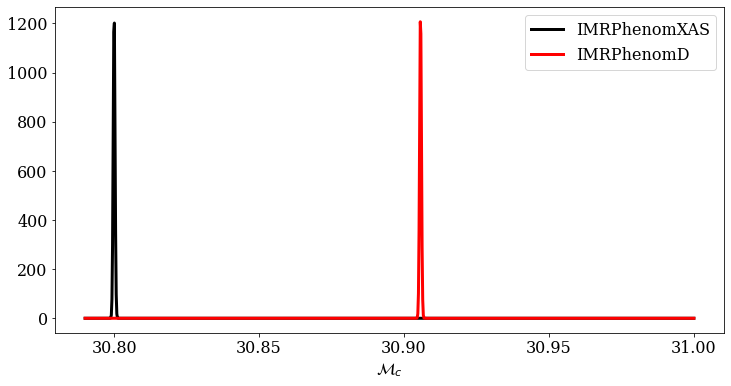

In [30]:
# GW150914
# https://arxiv.org/pdf/1606.01210.pdf
from scipy.stats import norm

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))

mc_inj = net1.inj_params["Mc"]
stat_err = net2.errs["Mc"]
bias = errors_th[0]

print(mc_inj)
print(bias)

mc = np.linspace(mc_inj-0.01, mc_inj+.2, 1000)

plt.plot(mc, norm.pdf(mc, mc_inj, stat_err), lw=3, color='k', label="IMRPhenomXAS")
# plt.plot(mc, norm.pdf(mc, mc_inj+0.103, stat_err),lw=3, color='orange', label="$\lambda \\approx 0.1$")
plt.plot(mc, norm.pdf(mc, mc_inj+bias, stat_err),lw=3, color='r', label="IMRPhenomD")

# plt.axvline(x=mc_inj, ymin=0.05, color='k', ls='--')
# plt.axvline(x=mc_inj+0.103,  ymin=0.05, color='orange', ls='--')
# plt.axvline(x=mc_inj+bias,  ymin=0.05, color='r', ls='--')

# plt.semilogy()
plt.xlabel("$\mathcal{M}_{c}$")
plt.legend()
plt.show()

# Plot the Bias across parameters

In [31]:
def plot_bias(param_list, errors_th, figsize=(12,25)):
    f, ax= plt.subplots(len(param_list), 1,  figsize=figsize) 
    ax = list(ax)
    for i, param in enumerate((param_list)):
        mu = net2.inj_params[param]
        sigma = net2.errs[param]

        x = np.linspace(mu-3*errors_th[i], mu+3*errors_th[i], 10000)

        stat_est = stats.norm.pdf(x, mu, sigma)
        stat_est = stat_est/np.max(stat_est)

        theory_est = stats.norm.pdf(x, mu+errors_th[i], sigma)
        theory_est = theory_est/ np.max(theory_est)

        ax[i].plot(x, stat_est, label=f"Approximate (IMRPhenomD) Est")
        ax[i].plot(x, theory_est, label=f"True (IMRPhenomXAS) Est")
        
        if i==0:
            ax[i].legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=14)

        
        ax[i].set_xlim(mu-2*errors_th[i], mu+3*errors_th[i])
        ax[i].set_xlabel(param, fontsize=20)

    plt.suptitle("Systematic Bias b/w IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    plt.tight_layout()
    plt.show()

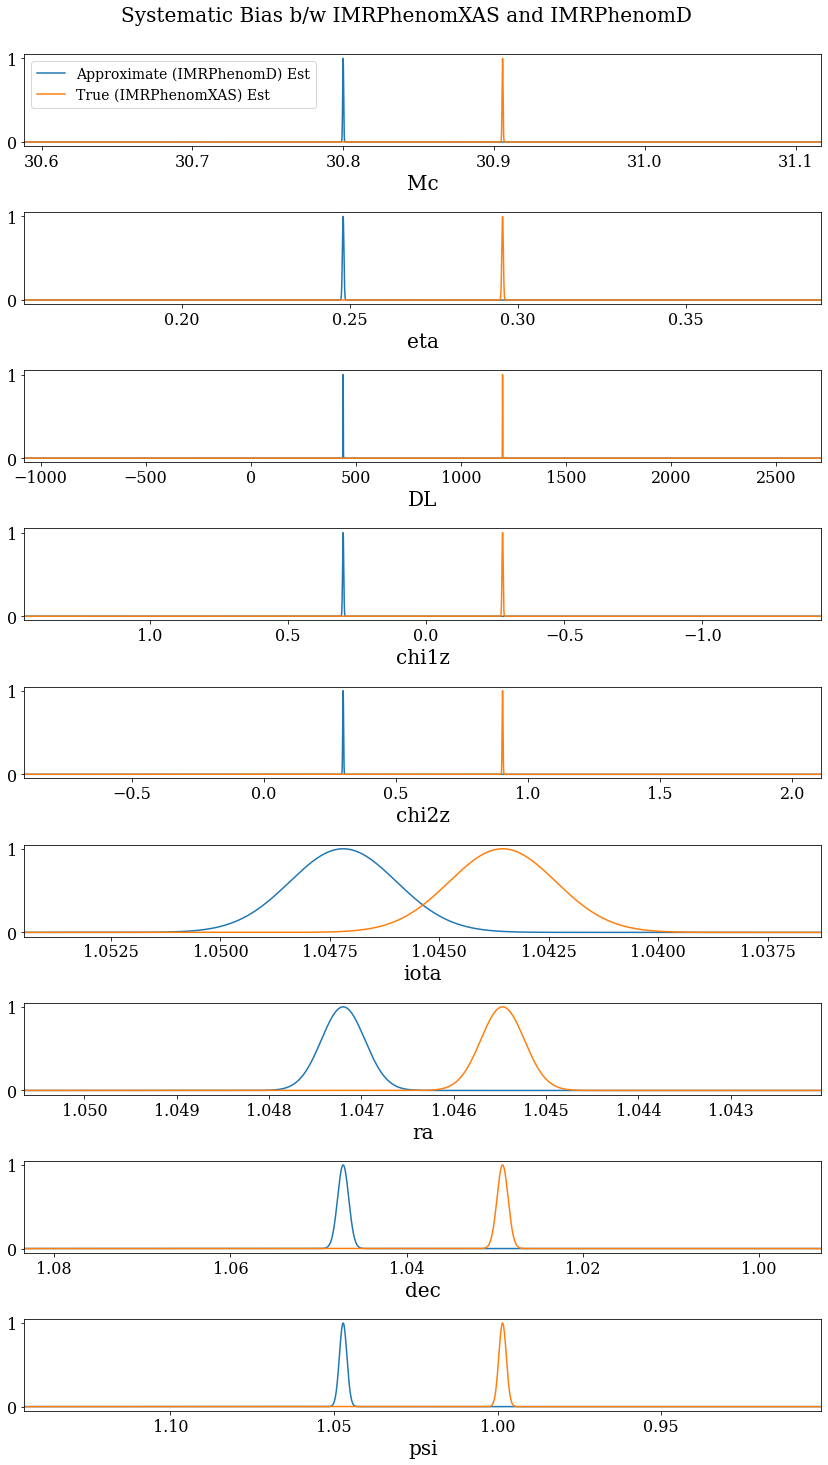

In [32]:
plot_bias(param_list[:], errors_th, figsize=(12, 20))


# Construct Hybrid Waveform

## Antenna Pattern Calculation

In [33]:
import antenna_pattern_np as gw_ap

In [34]:
def waveform_to_det_response(hp, hc, inj_params, detector):
    Mc = inj_params["Mc"]
    tc = inj_params["tc"]
    ra = inj_params["ra"]
    dec = inj_params["dec"]
    psi = inj_params["psi"]
    gmst0 = inj_params["gmst0"]
    use_rot = 0

    f = detector.f
    loc = detector.loc

    Fp, Fc, Flp = gw_ap.antenna_pattern_and_loc_phase_fac(f,Mc,tc,ra,dec,psi,gmst0,loc,use_rot)
    return Flp * (Fp * hp + Fc * hc)    

In [35]:
h1_response = waveform_to_det_response(net1.hfp, net1.hfc, inj_params, net1.detectors[0])
h2_response = waveform_to_det_response(net2.hfp, net2.hfc, inj_params, net2.detectors[0])

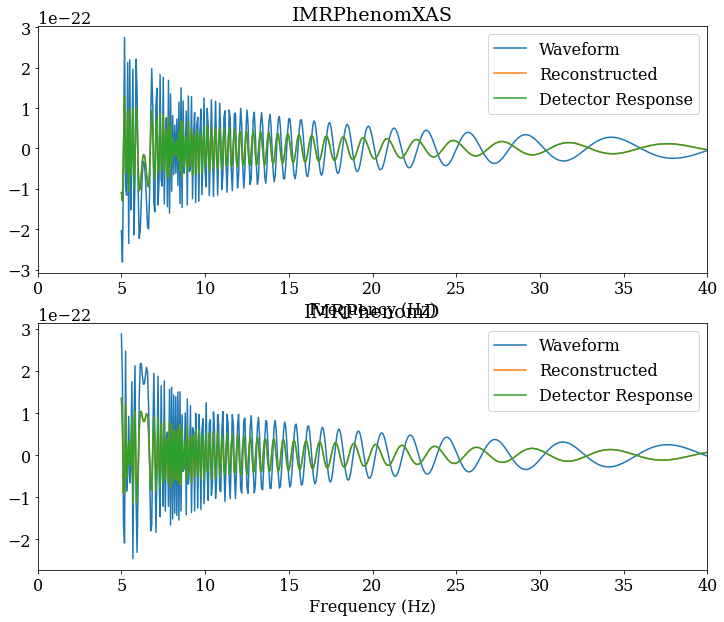

In [36]:
f, (ax)= plt.subplots(2, 1,  figsize=(12,10)) 

ax[0].plot(net1.f, np.real(net1.hfp), label="Waveform")
ax[0].plot(net1.f, np.real(h1_response), label="Reconstructed")
ax[0].plot(net1.detectors[0].f, np.real(net1.detectors[0].hf), label="Detector Response")
ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("IMRPhenomXAS")
ax[0].set_xlim(0, 40)
ax[0].legend()

ax[1].plot(net2.f, np.real(net2.hfp), label="Waveform")
ax[1].plot(net2.f, np.real(h2_response), label="Reconstructed")
ax[1].plot(net2.detectors[0].f, np.real(net2.detectors[0].hf), label="Detector Response")
ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("IMRPhenomD")
ax[1].set_xlim(0, 40)
ax[1].legend()

plt.show()

## Hybrid Waveform Calculation

Let's express the two waveforms using following decompositions:
$$ h^{(1)}_{lm}(f) = A^{(1)}_{lm}(f) \exp[{i \phi^{(1)}_{lm}(f)}]$$
$$ h^{(2)}_{lm}(f) = A^{(2)}_{lm}(f) \exp[{i \phi^{(2)}_{lm}(f)}]$$

We want to minimize the initial time difference, which can be expressed as a frequency-dependent phase factor $ \exp[{i (\Delta\phi)}] = \exp[{i ( \phi_a + \phi_b f)}] $

Therefore, our task is to find a phase offset $\Delta \phi$ that minimizes the integrated phase difference 
$$ \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  (\phi^{(2)}(f)+ \Delta \phi) \;\; df $$
$$ = \int_{f_{min}}^{f_{max}}  \phi^{(1)}(f) -  \phi^{(2)}(f) - \phi_a - (\phi_b \cdot f) \;\; df $$

In [37]:
def phase_diff_integral(phis, args):
    phi_a, phi_b = phis[0], phis[1]

    phi1, phi2, f_min, f_max, freq_range = args[0], args[1], args[2], args[3], args[4]
    phase_diff = np.sum(phi1 - phi2)
    return  np.abs(phase_diff - (phi_a*(f_max - f_min)) - (phi_b * (((f_max**2) /2) - ((f_min**2) /2))))


In [38]:
def get_delta_phi(hp1, hc1, hp2, hc2, detector):
    f_min = 5.
    f_max = 1024.
    d_f = 2**-4
    f = np.arange(f_min, f_max, d_f)

    Mc = inj_params["Mc"]
    tc = inj_params["tc"]
    ra = inj_params["ra"]
    dec = inj_params["dec"]
    psi = inj_params["psi"]
    gmst0 = inj_params["gmst0"]
    use_rot = 0

    f = detector.f
    loc = detector.loc

    Fp, Fc, Flp = gw_ap.antenna_pattern_and_loc_phase_fac(f,Mc,tc,ra,dec,psi,gmst0,loc,use_rot)

    h1 = Flp*(Fp*hp1 + Fc*hc1)
    h2 = Flp*(Fp*hp2 + Fc*hc2)

    phi1 = np.unwrap(np.angle(h1))   
    phi2 = np.unwrap(np.angle(h2))

    initial_guess = [1.0, 0.]
    args = [phi1, phi2, f_min, f_max, f]
    result = minimize(phase_diff_integral, initial_guess, args=args, method='Nelder-Mead')
    # print(result)
    
    phi_a_opt, phi_b_opt = result.x[0], result.x[1]


    delta_phi = phi_a_opt + (phi_b_opt*f)

    return delta_phi

In [39]:
# Hybrid Waveform
def get_hyb_wf(hp1, hc1, hp2, hc2, lam, opt_phi=False, detector=net1.detectors[0]):

    if (lam > 1. or lam < 0):
        raise Exception('lambda should be between 0.0 and 1.0. The value of lambda was: {}'.format(lam))

    # h_plus components
    a1_p = np.abs(hp1)
    phi1_p = np.unwrap(np.angle(hp1))  

    a2_p = np.abs(hp2)
    phi2_p = np.unwrap(np.angle(hp2))

    # h_cross components
    a1_c = np.abs(hc1)
    phi1_c = np.unwrap(np.angle(hc1))    

    a2_c = np.abs(hc2)
    phi2_c = np.unwrap(np.angle(hc2))

    if opt_phi:
        # Optimize for time shift of second waveform
        delta_phi = get_delta_phi(hp1, hc1, hp2, hc2, detector)
        phi2_p = (phi2_p + delta_phi) 
        phi2_c = (phi2_c + delta_phi) 

    # Construct Hybrid waveforms
    a_hyb_p = a1_p*(1-lam) + a2_p*(lam)
    phi_hyb_p = phi1_p*(1-lam) + phi2_p*(lam)

    a_hyb_c = a1_c*(1-lam) + a2_c*(lam)
    phi_hyb_c = phi1_c*(1-lam) + phi2_c*(lam)


    hp_hyb =  a_hyb_p * np.exp(1.j * phi_hyb_p)
    hc_hyb =  a_hyb_c * np.exp(1.j * phi_hyb_c)
    
    return hp_hyb, hc_hyb

In [40]:
hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam=0.5)
print(np.abs(np.sum(hp_hyb - net2.hfp)))
print(np.abs(np.sum(hc_hyb - net2.hfc)))

1.28650414990941e-20
6.4308928110131206e-21


In [41]:
from pycbc.types import FrequencySeries
delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[1].psd, delta_f=delta_f) # calculate mismatch using any one detector PSD

hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)
hp2_pyc = FrequencySeries(net2.hfp, delta_f=delta_f)

hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc)/psd).data)


lams = np.linspace(0, 1, 10)
inner_prods = np.zeros(10)

for l, lam in enumerate(lams):
    hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam)
    hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    
    hyb_norm = np.sum((hp_hyb_pyc * np.conjugate(hp_hyb_pyc)/psd).data)

    inner_prods[l] = np.abs(np.sum((hp1_pyc * np.conjugate(hp_hyb_pyc)/psd).data))
    inner_prods[l] = inner_prods[l]/ np.abs(np.sqrt(hp1_norm*hyb_norm))

print(inner_prods)

[1.         0.98778907 0.95429013 0.9080586  0.86036349 0.82096115
 0.79401833 0.77697597 0.76344048 0.74765302]


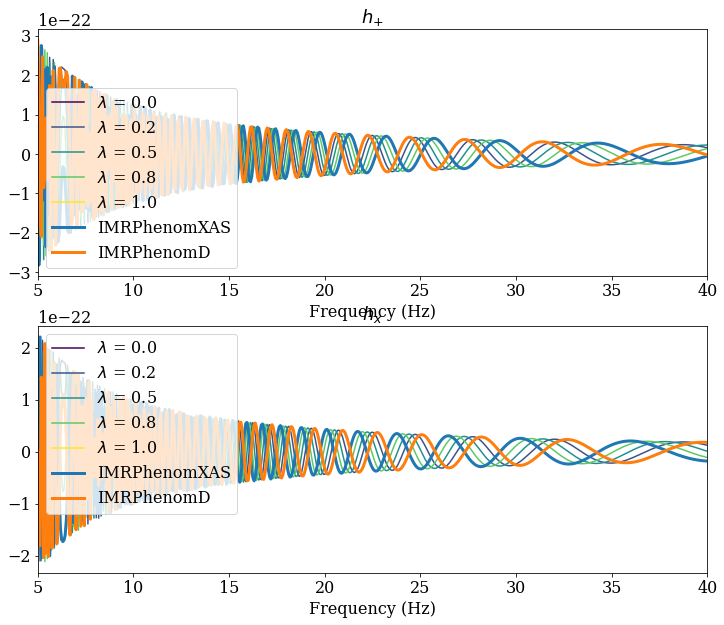

In [42]:
lams = np.linspace(0., 1., 5)
colors = plt.cm.viridis(lams)

f, (ax)= plt.subplots(2, 1,  figsize=(12,10)) 

for i, lam in enumerate(lams):
    # hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam)
    hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam)
    ax[0].plot(net2.f, np.real(hp_hyb), c=colors[i], label=f"$\lambda$ = {lam:.1f}")
    ax[1].plot(net2.f, np.real(hc_hyb), c=colors[i], label=f"$\lambda$ = {lam:.1f}")

ax[0].plot(net1.f, np.real(net1.hfp), lw=3, label="IMRPhenomXAS")
ax[0].plot(net2.f, np.real(net2.hfp), lw=3, label="IMRPhenomD")

ax[0].set_xlabel("Frequency (Hz)")
ax[0].set_title("$h_{+}$", fontsize=18)

ax[1].plot(net1.f, np.real(net1.hfc), lw=3, label="IMRPhenomXAS")
ax[1].plot(net2.f, np.real(net2.hfc), lw=3, label="IMRPhenomD")

ax[1].set_xlabel("Frequency (Hz)")
ax[1].set_title("$h_{x}$", fontsize=18)

ax[0].set_xlim(5, 40)
ax[0].legend()

ax[1].set_xlim(5, 40)
ax[1].legend()

plt.tight_layout
plt.show()

## Cutler-Vallisneri for Hybrid Waveforms

In [53]:
# Calculate the Theoretical Bias in Parameters based on Cutler-Valisneri formalism
# Use the proper interpolated fishers and derivatives

lams = np.linspace(0., 0.002, 10)
errors_th_lam = np.zeros((len(lams), len(param_list)))

for l, lam in enumerate(lams):
    inner_prod = np.zeros(len(param_list))
    cov_ap = np.linalg.inv(lam*net1.fisher + (1-lam)*net2.fisher)

    for d in range(len(network_spec)):
        # del_h_ap_all = net1.detectors[d].del_hf
        del_params_j = list(net1.detectors[d].del_hf.keys())

        hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=False)

        h_tr = net1.detectors[d].hf
        h_ap = waveform_to_det_response(hp_hyb, hc_hyb, inj_params, net1.detectors[d])

        psd = net2.detectors[d].psd
        freq_range = net2.detectors[d].f
        df = freq_range[1] - freq_range[0]

        for j, parameter_j in enumerate(del_params_j):
            del_h_ap_j = (1-lam)*net1.detectors[d].del_hf[parameter_j]  + lam*net2.detectors[d].del_hf[parameter_j] 
            
            # Inner Product
            inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
        
    # Calculate the theoretical bias across parameters
    errors_th_lam[l,:] = np.dot(cov_ap, inner_prod)


# # Calculate the Theoretical Bias in Parameters based on Cutler-Valisneri formalism
# # Interpolate the 'True' waveform for ease of calculation

# cov_ap = net2.cov
# lams = np.linspace(0., 0.002, 10)
# errors_th_lam = np.zeros((len(lams), len(param_list)))

# for l, lam in enumerate(lams):
#     inner_prod = np.zeros(len(param_list))

#     for d in range(len(network_spec)):
#         del_h_ap_all = net2.detectors[d].del_hf
#         del_params_j = list(del_h_ap_all.keys())

#         # hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam, opt_phi=True, detector=net1.detectors[d])
#         hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam, opt_phi=False)

#         h_tr = waveform_to_det_response(hp_hyb, hc_hyb, inj_params, net1.detectors[d])
#         h_ap = net2.detectors[d].hf

#         psd = net2.detectors[d].psd
#         freq_range = net2.detectors[d].f
#         df = freq_range[1] - freq_range[0]

#         for j, parameter_j in enumerate(del_params_j):
#             del_h_ap_j = del_h_ap_all[parameter_j]  
#             # Inner Product
#             inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
        
#     # Calculate the theoretical bias across parameters
#     errors_th_lam[l,:] = np.dot(cov_ap, inner_prod)


In [44]:
# Print only Mc errors
print(errors_th_lam[:,0])
print(lams)

[-1.58225840e-14  1.21966929e-04  2.43911859e-04  3.65833921e-04
  4.87732250e-04  6.09605985e-04  7.31454269e-04  8.53276251e-04
  9.75071084e-04  1.09683792e-03]
[0.         0.00022222 0.00044444 0.00066667 0.00088889 0.00111111
 0.00133333 0.00155556 0.00177778 0.002     ]


In [45]:
def plot_single_param_bias(error_th, param, lam=0., figsize=(12,25), xlim=None):
    f, ax= plt.subplots(1, 1,  figsize=figsize) 
    
    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    x = np.linspace(mu-30, mu+30, 10000)

    stat_est = stats.norm.pdf(x, mu, sigma)
    # stat_est = stat_est/np.max(stat_est)

    theory_est = stats.norm.pdf(x, mu+error_th, sigma)
    # theory_est = theory_est/ np.max(theory_est)

    ax.plot(x, stat_est, label=f"Approximate (IMRPhenomD) Est")
    ax.plot(x, theory_est, label=f"Hybrid (lam={lam:.3f}) Est")
    
    ax.legend(bbox_to_anchor=(0, 1), loc='upper left', fontsize=16)

    if xlim is None:
        ax.set_xlim(mu-2*error_th, mu+3*error_th)
    else:
        ax.set_xlim(xlim)
        
    ax.set_xlabel(param, fontsize=20)

    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.title("Systematic Bias b/w IMRPhenomXAS and IMRPhenomD", y=1.02, fontsize=20)
    # plt.tight_layout()
    plt.show()

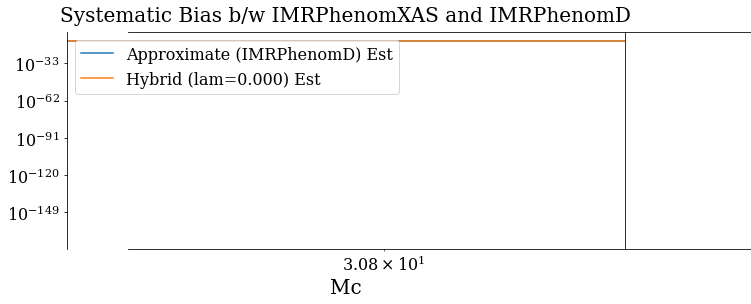

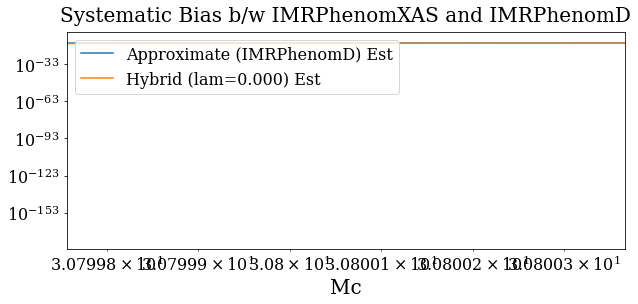

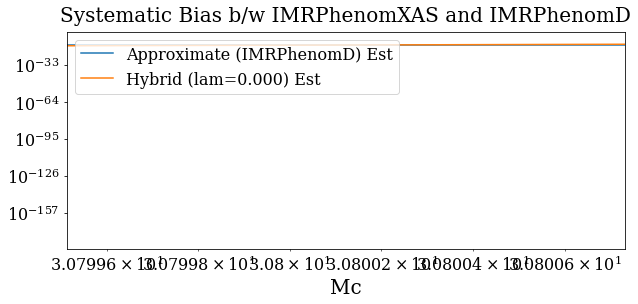

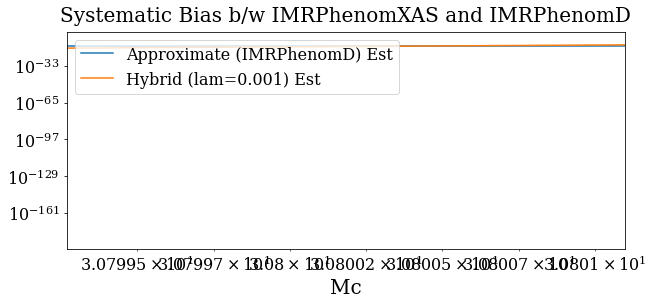

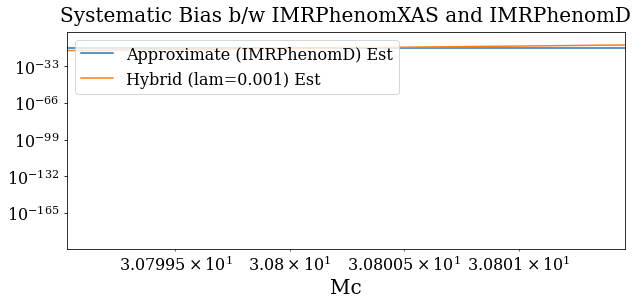

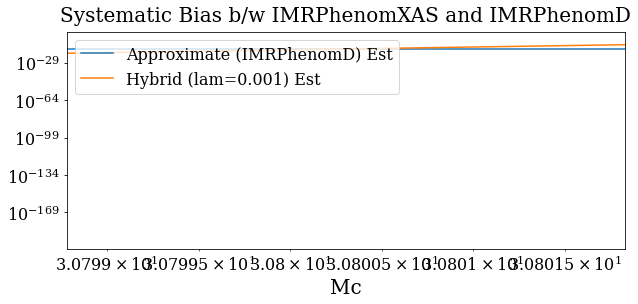

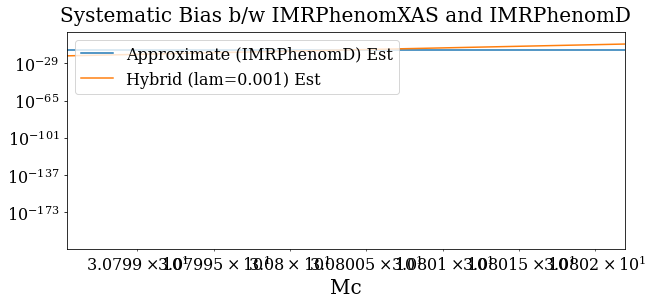

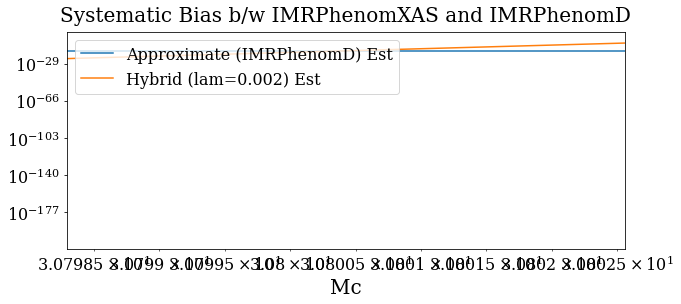

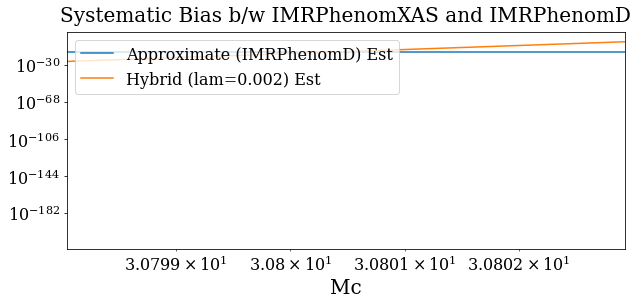

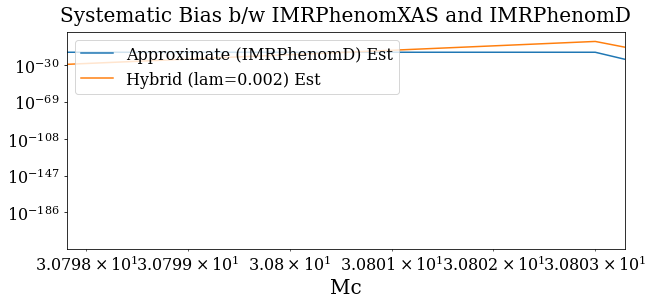

In [47]:
param = param_list
for i in range(len(lams[:])):
    plot_single_param_bias(errors_th_lam[i,0], lam=lams[i], param=param_list[0], figsize=(10, 4))

In [49]:
print(net2.errs["chi1z"])
errors_th_lam[:, 3]

0.0020628007176680266


array([4.91558664e-13, 2.77917814e-03, 5.54797634e-03, 8.30643001e-03,
       1.10545744e-02, 1.37924445e-02, 1.65200752e-02, 1.92375010e-02,
       2.19447565e-02, 2.46418758e-02])

# Make sure that the max lambda is not skipped over

The algorithm proceeds as follows:
1. We first assume that the maximum lambda is 1.0 (max possible lambda). 
2. At each lambda, we will compute the Cutler-Vallisneri bias for Mc. 
3. If the bias exceeds statistical error within the first 3 lambda increments, we will tighten the search window. This condition makes sure that there were enough steps in lambda space to see where we actually exceed the statistical error, and prevents sudden jumps between indices 0 and 1. 
4.  The new max lambda is decided as the lambda for which the previous search first exceeded statistical error. The new min lambda is one right before.
5. We repeat this process until the transition happens somewhere above index 2, and also until the search window has been narrowed at least thrice to ensure high precision.

In [50]:
param_index = 0

max_lam_index = 0
max_lam = 1.0
min_lam = 0.0
sigma_mc = np.abs(net2.errs["Mc"])
cov_ap = net2.cov

n_tries = 0
print(f"Statistical error on Mc: {sigma_mc:.3e}\n\n")

while (max_lam_index<2 or n_tries<3):
    print(f"Checking with max lambda; {max_lam:.3e}")
    n_tries += 1

    lams = np.linspace(min_lam, max_lam, 10)
    errors_th_lam = np.zeros(len(lams))

    for l, lam in enumerate(lams):
        inner_prod = np.zeros(len(param_list))

        for d in range(len(network_spec)):
            del_h_ap_all = net2.detectors[d].del_hf
            del_params_j = list(del_h_ap_all.keys())

            # hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam, opt_phi=True, detector=net1.detectors[d])
            hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam, opt_phi=False)

            h_tr = waveform_to_det_response(hp_hyb, hc_hyb, inj_params, net1.detectors[d])
            h_ap = net2.detectors[d].hf

            psd = net2.detectors[d].psd
            freq_range = net2.detectors[d].f
            df = freq_range[1] - freq_range[0]

            for j, parameter_j in enumerate(del_params_j):
                del_h_ap_j = del_h_ap_all[parameter_j]  
                # Inner Product
                inner_prod[j] += snr.scalar_product_freq_array(del_h_ap_j, h_tr - h_ap, psd, freq_range, df)
            
        # Calculate the theoretical bias across parameters
        errors_th_lam[l] = np.dot(cov_ap, inner_prod)[param_index]

        # Stop calculating biases for higher lambda if Statistical error has already been exceeded.
        if errors_th_lam[l] > net2.errs[param]:
            errors_th_lam[l:] = errors_th_lam[l]

    bias_mc = np.abs(errors_th_lam)
    max_lam_index = np.where(bias_mc > sigma_mc)[0][0]
    max_lam_index = np.where(bias_mc > sigma_mc)[0][0]
    try:
        max_lam = lams[max_lam_index]
        min_lam = lams[max_lam_index - 1]
    except:
        max_lam = lams[1]
        max_lam_index = 1
        min_lam = lams[0]

    print(f"errors over lambda: {errors_th_lam[0]}")
    print(f"Max lambda is {max_lam:.3f}")
    print(f"Next min lambda is {min_lam:.3f}")
    print(f"Max lambda index is {max_lam_index}\n")

print(max_lam)

Statistical error on Mc: 3.191e-04


Checking with max lambda; 1.000e+00


TypeError: unhashable type: 'list'

In [51]:
bias_mc = np.abs(errors_th_lam[:,0])
# max_lam_index = np.where(bias_mc <= sigma_mc)[0][-1]
# max_lam = lams[max_lam_index]
print(bias_mc)
print(sigma_mc)
print(max_lam_index)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

# Plot bias vs lambda

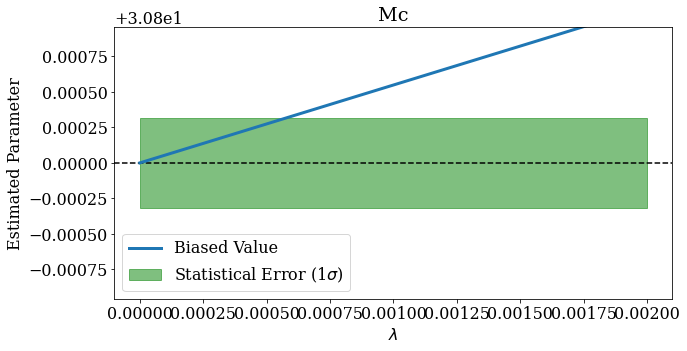

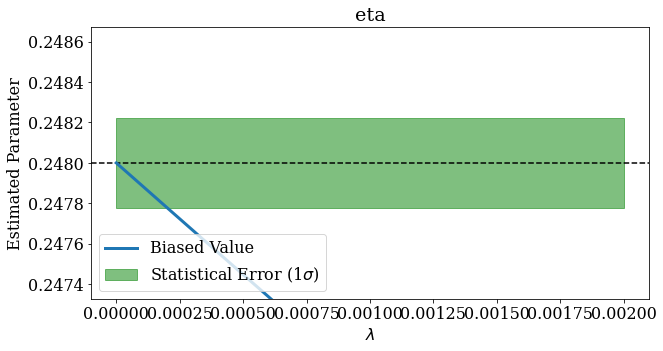

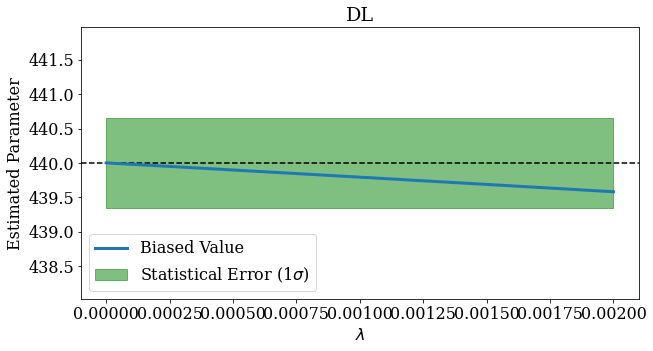

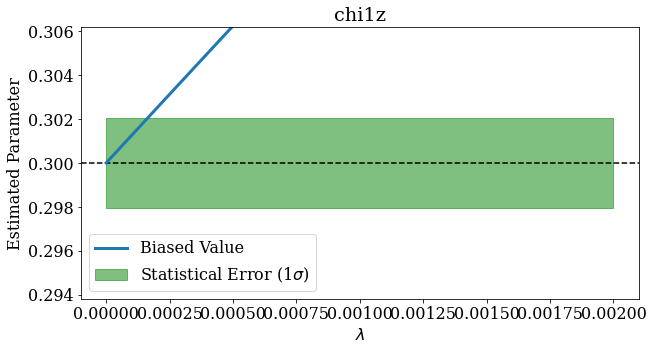

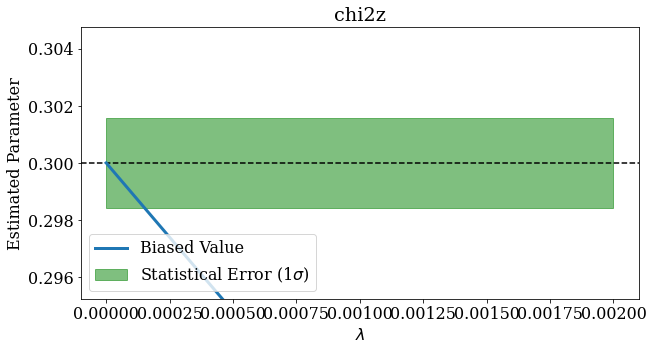

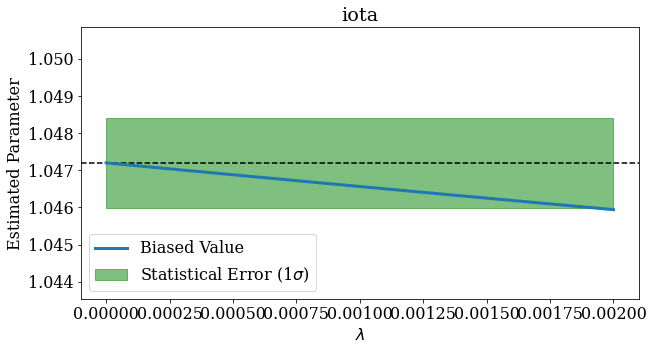

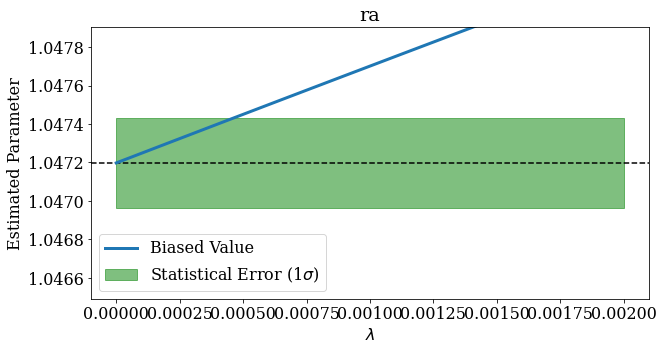

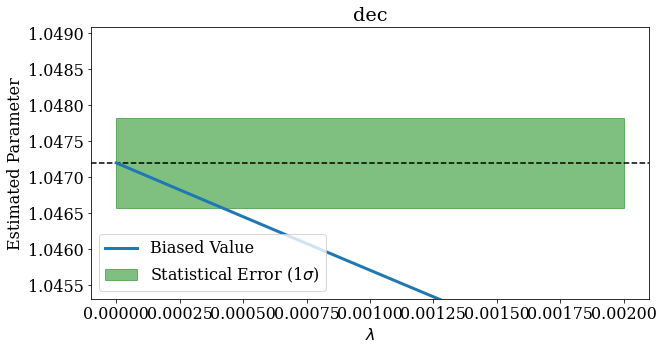

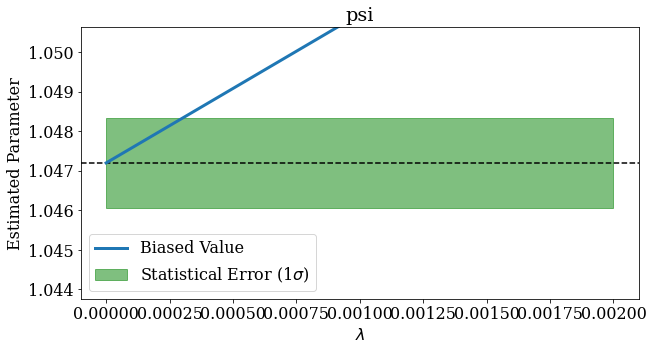

In [54]:
for p, param in enumerate(param_list):

    f, ax= plt.subplots(1, 1,  figsize=(10, 5)) 

    mu = net2.inj_params[param]
    sigma = net2.errs[param]

    plt.axhline(mu, color='k', linestyle='--' )
    plt.fill_between(lams, mu-sigma, mu+sigma, alpha=0.5, color='g', label="Statistical Error (1$\sigma$)")
    plt.plot(lams, mu+errors_th_lam[:, p], color='C0', lw=3, label='Biased Value')

    plt.legend(loc="lower left")

    plt.ylabel(f"Estimated Parameter")
    plt.xlabel("$\lambda$")
    plt.title(param)

    plt.ylim(mu-3*sigma, mu+3*sigma)

    plt.show()

# Minimum Lambda for Mc Bias below Statistical Error

In [19]:
sigma_mc = np.abs(net2.errs["Mc"])
bias_mc = np.abs(errors_th_lam[:,0])


max_lam = lams[np.where(bias_mc <= sigma_mc)[0][-1]]

print(f"Max lambda for Mc = {max_lam:.3f}")

from pycbc.types import FrequencySeries
from pycbc.filter import match


delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[1].psd, delta_f=delta_f)
hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)


hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, max_lam, opt_phi=False)
hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
min_faith, i = match(hp1_pyc, hp_hyb_pyc, psd=psd, low_frequency_cutoff=net1.f[0])

print(f"Min faithfulness for Mc = {min_faith:.6f}")

NameError: name 'errors_th_lam' is not defined

# Faithfulness/ Inner Product

In [51]:
from pycbc.types import FrequencySeries
from pycbc.filter import match

delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[0].psd, delta_f=delta_f)
hp_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)
sp_pyc = FrequencySeries(net2.hfp, delta_f=delta_f)


m, i = match(hp_pyc, sp_pyc, psd=psd, low_frequency_cutoff=net1.f[0])
print('The match is: {:.4f}'.format(m))

The match is: 0.8821


In [52]:
def wf_inner(a, b, psd):
    a_norm = np.sqrt(np.sum((a * np.conjugate(a)).data))
    b_norm = np.sqrt(np.sum((b * np.conjugate(b)).data))
    return np.abs(np.sum((a * np.conjugate(b)).data)) / (a_norm*b_norm)

In [53]:
hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)
hp2_pyc = FrequencySeries(net2.hfp, delta_f=delta_f)
psd = FrequencySeries(net1.detectors[0].psd, delta_f=delta_f)


hp1_norm = np.sqrt(np.sum((hp1_pyc * np.conjugate(hp1_pyc)).data))
hp2_norm = np.sqrt(np.sum((hp2_pyc * np.conjugate(hp2_pyc)).data))

np.abs(np.sum((hp2_pyc * np.conjugate(hp2_pyc)).data)) / (hp2_norm*hp2_norm*psd.data)

array([7.88651231e+45+0.j, 9.14793665e+45+0.j, 1.05683305e+46+0.j, ...,
       1.63912658e+49+0.j, 1.63904068e+49+0.j, 1.63895479e+49+0.j])

In [54]:
lams = np.linspace(0., 1, 30)
faiths_phi_opt = np.zeros(len(lams))
faiths_no_opt = np.zeros(len(lams))
inner_prods = np.zeros(len(lams))
inner_prods_no_psd = np.zeros(len(lams))


delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[1].psd, delta_f=delta_f)
hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)

for l, lam in enumerate(lams):
    hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=False)
    hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    faiths_no_opt[l], i = match(hp1_pyc, hp_hyb_pyc, psd=psd, low_frequency_cutoff=net1.f[0])
    
    hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc)/psd).data)
    hyb_norm = np.sum((hp_hyb_pyc * np.conjugate(hp_hyb_pyc)/psd).data)

    inner_prods[l] = np.abs(np.sum((hp1_pyc * np.conjugate(hp_hyb_pyc)/psd).data))
    inner_prods[l] = inner_prods[l]/ np.abs(np.sqrt(hp1_norm*hyb_norm))

    inner_prods_no_psd[l] = np.abs(np.dot(hp1_pyc,np.conjugate(hp_hyb_pyc)))
    hp1_norm = np.sum((hp1_pyc * np.conjugate(hp1_pyc)).data)
    hyb_norm = np.sum((hp_hyb_pyc * np.conjugate(hp_hyb_pyc)).data)
    inner_prods_no_psd[l] = inner_prods_no_psd[l]/ (np.abs(np.sqrt(hp1_norm*hyb_norm)))
    

    # hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=True)
    # hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    # faiths_phi_opt[l], i =  match(hp1_pyc, hp_hyb_pyc, psd=psd, low_frequency_cutoff=net1.f[0])

# inner_prods = inner_prods 

In [55]:
# inner_prods_old
inner_prods

array([1.        , 0.99880351, 0.99527538, 0.98961863, 0.98216243,
       0.97332245, 0.96355179, 0.95328946, 0.94291444, 0.93271209,
       0.92285771, 0.91341869, 0.90437316, 0.89564026, 0.88711546,
       0.87870437, 0.87034906, 0.86204318, 0.85383332, 0.84580662,
       0.83806665, 0.8307014 , 0.82374959, 0.81717242, 0.81083737,
       0.80451928, 0.79791987, 0.79070322, 0.78254133, 0.77316165])

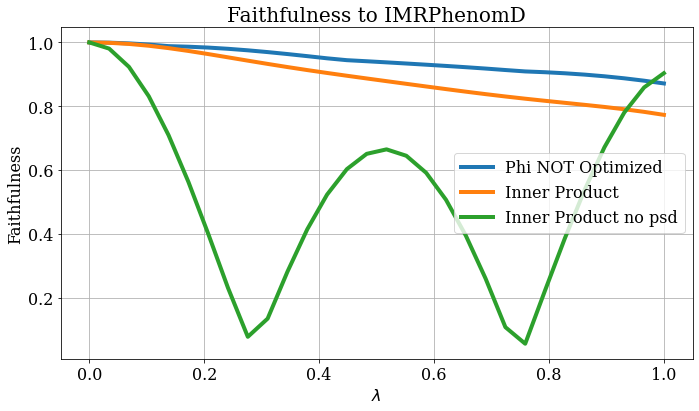

In [56]:
f, (ax)= plt.subplots(1, 1,  figsize=(10,6)) 

lw=4
# plt.plot(lams, faiths_phi_opt, lw=lw, label="Phi Optimized")
plt.plot(lams, faiths_no_opt, lw=lw, label="Phi NOT Optimized")
plt.plot(lams, inner_prods, lw=lw, label="Inner Product")
plt.plot(lams, inner_prods_no_psd, lw=lw, label="Inner Product no psd")


plt.ylabel('Faithfulness', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Faithfulness to IMRPhenomD', fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

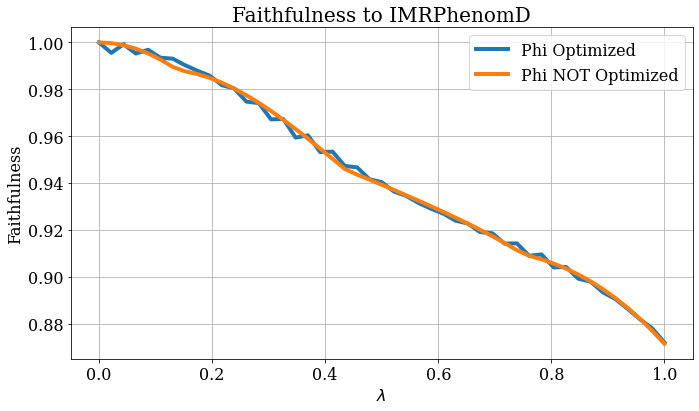

In [57]:
lams = np.linspace(0., 1., 47)
faiths_phi_opt = np.zeros(len(lams))
faiths_no_opt = np.zeros(len(lams))

delta_f = net1.f[1] - net1.f[0]
psd = FrequencySeries(net1.detectors[1].psd, delta_f=delta_f)
hp1_pyc = FrequencySeries(net1.hfp, delta_f=delta_f)

for l, lam in enumerate(lams):
    hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=False)
    hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    faiths_no_opt[l], i = match(hp1_pyc, hp_hyb_pyc, psd=psd, low_frequency_cutoff=net1.f[0])
    
    hp_hyb, hc_hyb = get_hyb_wf(net1.hfp, net1.hfc, net2.hfp, net2.hfc, lam, opt_phi=True)
    hp_hyb_pyc = FrequencySeries(hp_hyb, delta_f=delta_f)
    faiths_phi_opt[l], i =  match(hp1_pyc, hp_hyb_pyc, psd=psd, low_frequency_cutoff=net1.f[0])

f, (ax)= plt.subplots(1, 1,  figsize=(10,6)) 

lw=4
plt.plot(lams, faiths_phi_opt, lw=lw, label="Phi Optimized")
plt.plot(lams, faiths_no_opt, lw=lw, label="Phi NOT Optimized")


plt.ylabel('Faithfulness', fontsize=16)
plt.xlabel('$\lambda$', fontsize=16)

plt.title('Faithfulness to IMRPhenomD', fontsize=20)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()

In [24]:
def match_HM_k_opt_LAL(hp1, hc1, hp2, hc2, iota, phi, kappa, deltaF, Sn, zpfact=2):
    # Check if the two waveform have the same size
    wf1_FD = np.cos(kappa)*hp1 + np.sin(kappa)*hc1
    # Compute the norm of the true waveform
    norm1 = np.sqrt(np.sum(np.abs(wf1_FD)**2/Sn))
    

    # Define the match as a function of phi. This match is analytically optimized over kappa
    def match_HM_phi_kopt(x):
        try:
            # Unpacking for multiD mimimization
            len(x)
            x = x[0]
        except:
            pass
        

        n = len(hp2)
        A_p = np.sqrt(np.sum(np.abs(hp2)**2/Sn))
        A_c = np.sqrt(np.sum(np.abs(hc2)**2/Sn))

        if A_c/A_p>1e-8: #if we really have two non zero polarizations
            Ipc = np.real(np.dot(np.conjugate(hp2),hc2/Sn))
            integrand = np.conjugate(hp2)*wf1_FD/Sn
            rho_p = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))
            integrand = np.conjugate(hc2)*wf1_FD/Sn
            rho_c = n*zpfact*np.real(np.fft.ifft(integrand,n=n*zpfact))

            alpha = np.sqrt(rho_p**2 + rho_c**2) # this is a time series
            kappa0 = np.angle(rho_p+1.j*rho_c) # this is a time series

            gamma = np.sqrt(((A_p**2-A_c**2)/2.)**2+Ipc**2)
            sigma0 = np.angle((A_p**2-A_c**2)/2.+1.j*Ipc)
            beta = (A_p**2+A_c**2)/2.

            #print A_p,A_c,Ipc,gamma,sigma0,beta
            num = np.max(alpha*np.sqrt(beta-gamma*np.cos(2*kappa0-sigma0)))
            den = norm1*np.sqrt(beta**2-gamma**2)
            overlap = num/den
        else:
            integrand = np.conjugate(hp2)*wf1_FD/Sn
            ifftterm = n*zpfact*np.fft.ifft(integrand,n=n*zpfact)
            maxifftterm = np.max([np.max(np.real(ifftterm)),np.max(-np.real(ifftterm))])
            overlap = maxifftterm/(norm1*A_p)

        return -overlap

    # Numerically optimize over phi
    # First find the minimum in a discrete manner
    phi_ini_guess = np.linspace(0.,2*np.pi,num=40)
    discrete_phi_min_index = np.argmin(np.array([match_HM_phi_kopt(phi_val) for phi_val in phi_ini_guess]))
    discrete_phi_min = phi_ini_guess[discrete_phi_min_index]
    res =minimize(match_HM_phi_kopt,x0=[discrete_phi_min,], method='Nelder-Mead')
    return -match_HM_phi_kopt(res.x)


def cartesian_product(*arrays):
    la = len(arrays)
    dtype = np.result_type(*arrays)
    arr = np.empty([len(a) for a in arrays] + [la], dtype=dtype)
    for i, a in enumerate(np.ix_(*arrays)):
        arr[...,i] = a
    return arr.reshape(-1, la)


In [25]:
iota, phi_c, kappa = 0. , 0., 0.
theta, phi, psi = np.pi/3, np.pi/3, np.pi/3

Fplus =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.cos(2*psi) - np.cos(theta)*np.sin(2*phi)*np.sin(2*psi)
Fcross =((1+np.cos(theta)**2)/2)*np.cos(2*phi)*np.sin(2*psi) + np.cos(theta)*np.sin(2*phi)*np.cos(2*psi)

kappa = -1j* np.log((Fplus + 1j*Fcross) / (np.sqrt(Fplus**2 + Fcross**2)))

match_HM_k_opt_LAL(net2.hfp, net2.hfc, net1.hfp, net1.hfc, iota, phi_c, kappa , df, net1.detectors[0].psd, zpfact=8)

0.9995538862782859

In [26]:
lams = np.linspace(0., 1., 10)
faiths_phi_opt = np.zeros(len(lams))
faiths_no_opt = np.zeros(len(lams))


for l, lam in enumerate(lams):
    hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam, opt_phi=True)
    faiths_phi_opt[l] = match_HM_k_opt_LAL(hp_hyb, hc_hyb, net2.hfp, net2.hfc, iota, phi_c, kappa , df, net1.detectors[0].psd, zpfact=8)

    hp_hyb, hc_hyb = get_hyb_wf(net2.hfp, net2.hfc, net1.hfp, net1.hfc, lam, opt_phi=False)
    faiths_no_opt[l] = match_HM_k_opt_LAL(hp_hyb, hc_hyb, net2.hfp, net2.hfc, iota, phi_c, kappa , df, net1.detectors[0].psd, zpfact=8)